# Batting Average Analysis
## For the start(ish) of the 2017 season
### MSP 04.29.2017

This jupyter notebook lays out some for for investigating average projections in 2017.

Full disclosure: I assumed going into this season that I'd be able to win batting average solely by picking an entire team of above-average batting average guys. Let's see how that belief holds up through this analysis...

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from random import randrange
import scipy.stats as sst




In [19]:
# now read in all the data: it's a lot, but is set up this way so that
#  we can slice across batting order.

#
# general fangraphs data for players
#
# all with > 100 PA at given lineup position

def read_batting_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG","playerid"),\
                         'formats': ('S20','S20','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4','i2')},\
                 skip_header=1,delimiter=',')
    return BatData


def read_individual_game_data(infile):
    BatData = np.genfromtxt(infile,\
                  dtype={'names': ("Date","Team","Opp","BO","Pos","G","AB","PA","H",\
                                   "1B","2B","3B","HR","R","RBI","BB","IBB",
                                   "SO","HBP","SF","SH","GDP","SB","CS","AVG"),\
                         'formats': ('S20','S20','S20','i2','S4','i2','f4','f4','f4',\
                                     'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4')},\
                 skip_header=2,delimiter=',')
    return BatData


Beltre2016 = read_individual_game_data('2016Batting/BeltreLog2016.csv')
Trout2016 = read_individual_game_data('2016Batting/TroutLog2016.csv')

Altuve2016 = read_individual_game_data('2016Batting/AltuveLog2016.csv')
Altuve2017 = read_individual_game_data('2016Batting/AltuveLog2017.csv')


Lemahieu2016 = read_individual_game_data('2016Batting/LemahieuLog2016.csv')
Lemahieu2017 = read_individual_game_data('2016Batting/LemahieuLog2017.csv')



Total2016   = read_batting_data('2016Batting/TotalBatting.csv')



# the spreadsheet below has been adjusted to skip 'des', which routinely has commas. C'mon guys! This needs to be machine readable!
def read_statcast_data(infile):
    outdict = np.genfromtxt(infile,\
        dtype={'names': ("pitch_type","game_date",\
                         "release_speed","x0","z0","player_name","batter","pitcher",\
                         "events","description","spin_dir","spin_rate","break_angle",\
                         "break_length","zone","game_type","stand","p_throws",\
                         "home_team","away_team","type","hit_location","bb_type",\
                         "balls","strikes","game_year","pfx_x","pfx_z","px","pz",\
                         "on_3b","on_2b","on_1b","outs_when_up","inning","inning_topbot",\
                         "hc_x","hc_y","tfs","tfs_zulu","catcher","umpire","sv_id",\
                         "vx0","vy0","vz0","ax","ay","az","sz_top","sz_bot","hit_distance_sc",\
                         "launch_speed","launch_angle","effective_speed","release_spin_rate",\
                         "release_extension","game_pk",\
                         "pos1_id","pos2_id","pos3_id",\
                         "pos4_id","pos5_id","pos6_id",\
                         "pos7_id","pos8_id","pos9_id",\
                         "release_pos_y","estimated_ba_using_speedangle","estimated_woba_using_speedangle",\
                         "woba_value","woba_denom","babip_value","iso_value"),\
                'formats': ('S2','S20',\
                            'f4','S20','S20','S20','S20','S20',\
                            'S40','S40','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20',\
                            'S20','S20','S20','S20','S20','S20','S20','S20','S20',\
                            'f4','f4','f4','f4',
                            'S20','S20',\
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4',
                            'f4','f4','f4','f4')},\
                 skip_header=1,delimiter=',')
    return outdict


AugustHits = read_statcast_data('2016Batting/August2016Hits.csv')

AugustOuts = read_statcast_data('2016Batting/August2016Outs.csv')






BlahBlahBlah

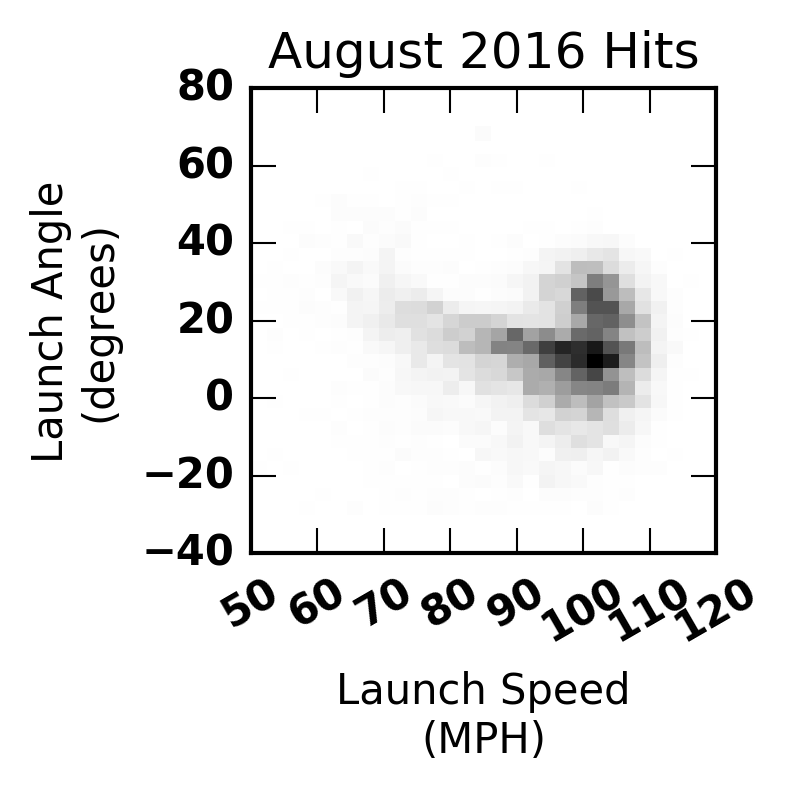

In [26]:

xbins = np.linspace(50.,120.,30)
ybins = np.linspace(-30.,70.,30)

ghits = np.where( (AugustHits['launch_speed'] != 90) | (AugustHits['launch_angle'] > 0))[0]

H, xedges, yedges = np.histogram2d(AugustHits['launch_speed'][ghits],AugustHits['launch_angle'][ghits], \
                                   bins=(xbins,ybins))
H = H.T/np.sum(H) # Let each row list bins with common y range.


ghits = np.where( (AugustOuts['launch_speed'] != 90) | (AugustOuts['launch_angle'] > 0))[0]

G, xedges, yedges = np.histogram2d(AugustOuts['launch_speed'][ghits],AugustOuts['launch_angle'][ghits], \
                                   bins=(xbins,ybins))
G = G.T/np.sum(G)  # Let each row list bins with common y range.



fig,ax = plt.subplots(figsize=(2,2))
ax.set_title('August 2016 Hits')
X, Y = np.meshgrid(xedges, yedges)
X2, Y2 = np.meshgrid(xbins,ybins)
ax.pcolormesh(X, Y, H/(G+1.),cmap=cm.Greys)
ax.set_ylabel('Launch Angle\n(degrees)')
ax.set_xlabel('Launch Speed\n(MPH)')

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")



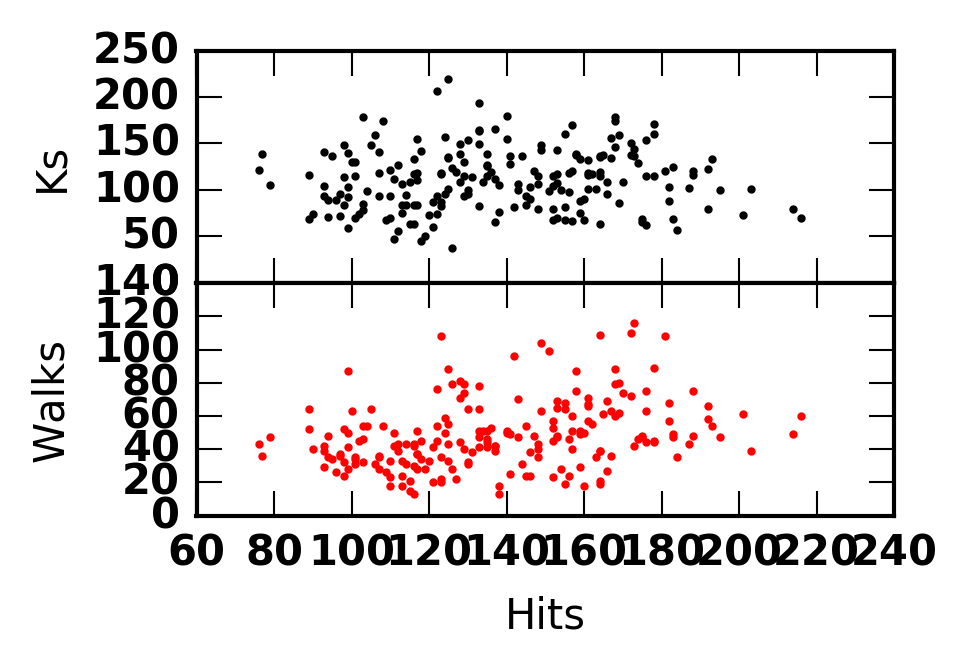

In [32]:
hs = Total2016['H']
pas = Total2016['PA']
sos = Total2016['SO']
bbs = Total2016['BB']
names = Total2016['Name']

g_pas = np.where(pas>400)[0]


fig = plt.figure(figsize=(3,2))

plt.subplots_adjust(hspace=0.001)

ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.scatter(hs[g_pas],sos[g_pas],color='black',s=1.)
#ax.text(80,0.93,'Walks',size=8)


#ax.axis([0.,120.,0.75,1.0])
ax.set_ylabel('Ks')
ax.set_xticklabels(())

ax2.scatter(hs[g_pas],bbs[g_pas],color='red',s=1.)
#ax2.axis([0.,120.,0.75,1.0])
#ax2.text(80,0.93,'Sacrifices',color='red',size=8)

ax2.set_ylabel('Walks')
ax2.set_xlabel('Hits')



----Beltre----
Mean:  7.7123
Sigma:  2.69316332776
Skew:  -0.549236616375
SkewSigma:  -0.124269755756
----Lemahieu----
Mean:  8.8469
Sigma:  3.12682912709
Skew:  -0.353957598916
SkewSigma:  -0.0640169556276
----Altuve----
Mean:  9.136
Sigma:  3.43413802868
Skew:  -0.498386823327
SkewSigma:  -0.0783140946103
----Trout----
Mean:  7.4849
Sigma:  3.01100846727
Skew:  0.302374865717
SkewSigma:  0.0578732302105


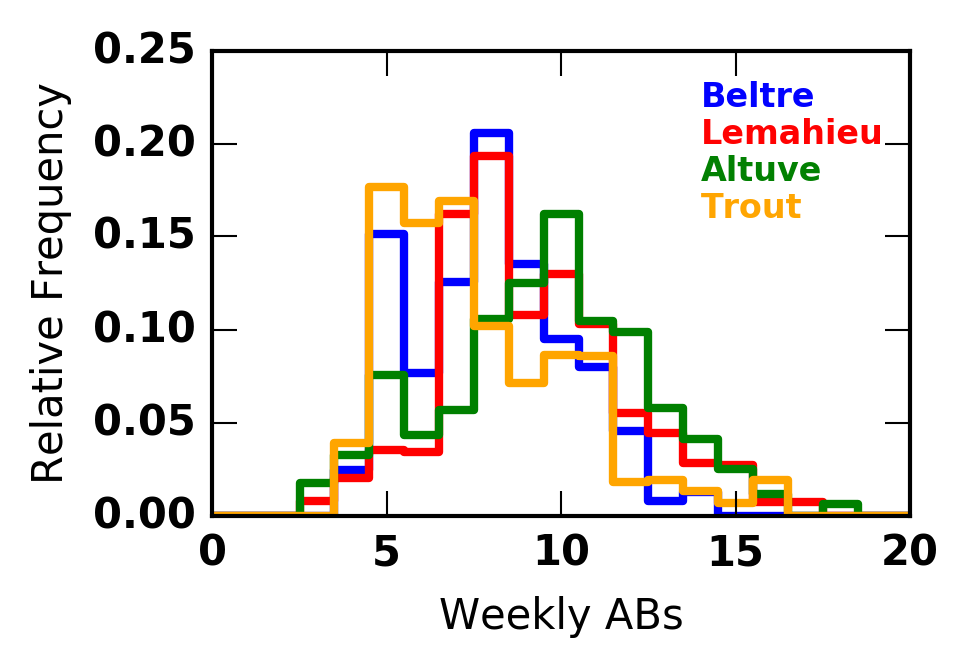

In [46]:


def ab_simulate(PlayerNotebook,Stat='AB',bins=np.arange(0,45,1),nsims=10000,verbose=1,ngames=7):
    
    vals = np.zeros(bins.shape[0])
    
    tvals = np.zeros(nsims)
    
    for indx in range(0,nsims):
        
        random_index = randrange(0,len(PlayerNotebook[Stat]))
        if random_index > len(PlayerNotebook[Stat])-ngames:
            continue
            
        vals[np.sum(PlayerNotebook[Stat][random_index:random_index+ngames])] += 1
        tvals[indx] = np.sum(PlayerNotebook[Stat][random_index:random_index+ngames])
    
    if verbose:
        print 'Mean: ',np.mean(tvals)
        print 'Sigma: ',np.std(tvals)
        print 'Skew: ',sst.skew(tvals)
        print 'SkewSigma: ',sst.skew(tvals)/np.std(tvals)**1.5

    return bins,vals,tvals

print '----Beltre----'
BeltreB,BeltreV,BeltreT = ab_simulate(Beltre2016,Stat='H')

print '----Lemahieu----'
LemahieuB,LemahieuV,LemahieuT = ab_simulate(Lemahieu2016,Stat='H')

print '----Altuve----'
AltuveB,AltuveV,AltuveT = ab_simulate(Altuve2016,Stat='H')

print '----Trout----'
TroutB,TroutV,TroutT = ab_simulate(Trout2016,Stat='H')





plt.figure(figsize=(3,2))
plt.plot(BeltreB,BeltreV/10000.,drawstyle='steps-mid',color='blue')
plt.plot(LemahieuB,LemahieuV/10000.,drawstyle='steps-mid',color='red')
plt.plot(AltuveB,AltuveV/10000.,drawstyle='steps-mid',color='green')
plt.plot(TroutB,TroutV/10000.,drawstyle='steps-mid',color='orange')

plt.text(14,0.22,'Beltre',color='blue',size=8)
plt.text(14,0.2,'Lemahieu',color='red',size=8)
plt.text(14,0.18,'Altuve',color='green',size=8)
plt.text(14,0.16,'Trout',color='orange',size=8)



plt.ylabel('Relative Frequency')
plt.xlabel('Weekly ABs')
_ = plt.axis([0.0,20.,0.,0.25])


#4.21 PA/game for average 5 hitter

----Beltre----
Mean:  0.271967284337
Sigma:  0.0960935493493
Skew:  -1.73298746801
SkewSigma:  -58.1773680357
----Lemahieu----
Mean:  0.314176356876
Sigma:  0.116396608836
Skew:  -1.48394975285
SkewSigma:  -37.3687615093
----Altuve----
Mean:  0.316881442666
Sigma:  0.11220181598
Skew:  -1.51035130543
SkewSigma:  -40.1863114963
----Trout----
Mean:  0.293776210874
Sigma:  0.103862809967
Skew:  -1.50914996062
SkewSigma:  -45.0860610332


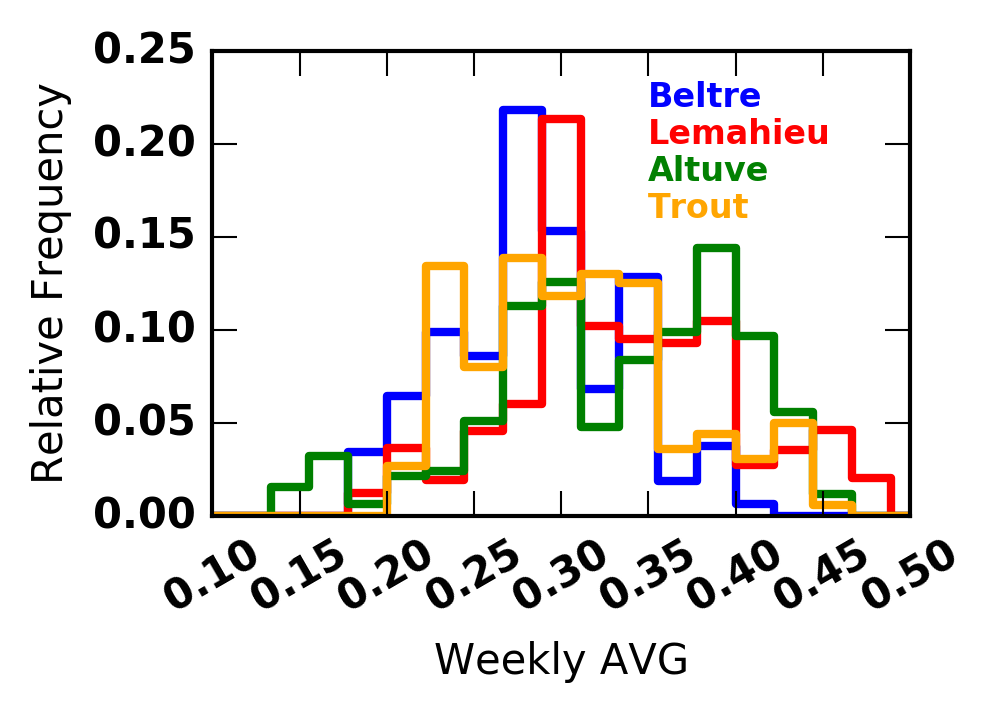

In [50]:


def avg_simulate(PlayerNotebook,Stat='AB',bins=np.linspace(.100,.500,19),nsims=10000,verbose=1,ngames=7):
    
    vals = np.zeros(bins.shape[0])
    
    tvals = np.zeros(nsims)
    
    for indx in range(0,nsims):
        
        random_index = randrange(0,len(PlayerNotebook[Stat]))
        if random_index > len(PlayerNotebook[Stat])-ngames:
            continue
            
        avg = np.sum(PlayerNotebook['H'][random_index:random_index+ngames])/np.sum(PlayerNotebook['AB'][random_index:random_index+ngames])
        
        bpos = (avg - bins[0])/(bins[1]-bins[0])
        
        if (bpos > 0) & (bpos < len(bins)-1):
            vals[bpos] += 1
        tvals[indx] = avg
    
    if verbose:
        print 'Mean: ',np.mean(tvals)
        print 'Sigma: ',np.std(tvals)
        print 'Skew: ',sst.skew(tvals)
        print 'SkewSigma: ',sst.skew(tvals)/np.std(tvals)**1.5

    return bins,vals,tvals


ngames = 14
print '----Beltre----'
BeltreB,BeltreV,BeltreT = avg_simulate(Beltre2016,ngames=ngames)

print '----Lemahieu----'
LemahieuB,LemahieuV,LemahieuT = avg_simulate(Lemahieu2016,ngames=ngames)

print '----Altuve----'
AltuveB,AltuveV,AltuveT = avg_simulate(Altuve2016,ngames=ngames)

print '----Trout----'
TroutB,TroutV,TroutT = avg_simulate(Trout2016,ngames=ngames)





fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.plot(BeltreB,BeltreV/10000.,drawstyle='steps-mid',color='blue')
ax.plot(LemahieuB,LemahieuV/10000.,drawstyle='steps-mid',color='red')
ax.plot(AltuveB,AltuveV/10000.,drawstyle='steps-mid',color='green')
ax.plot(TroutB,TroutV/10000.,drawstyle='steps-mid',color='orange')

ax.text(0.35,0.22,'Beltre',color='blue',size=8)
ax.text(0.35,0.2,'Lemahieu',color='red',size=8)
ax.text(0.35,0.18,'Altuve',color='green',size=8)
ax.text(0.35,0.16,'Trout',color='orange',size=8)



ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Weekly AVG')
_ = ax.axis([.100,.5,0.,0.25])

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("center")




#4.21 PA/game for average 5 hitter